## EDA

In [1]:
!pip install graphframes

In [2]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from pyspark.ml.feature import HashingTF, MinHashLSH
from graphframes import GraphFrame

In [3]:
# Start Spark session with GraphFrames support
spark = SparkSession.builder.appName("BigDataProject").config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12").getOrCreate()

# GraphFrames needs a checkpoint dir
spark.sparkContext.setCheckpointDir("/tmp/graphframes_checkpoint")

In [4]:
# Load CSV datasets
orders = spark.read.csv("orders.csv", header=True, inferSchema=True)
order_prior = spark.read.csv("order_products__prior.csv", header=True, inferSchema=True)
order_train = spark.read.csv("order_products__train.csv", header=True, inferSchema=True)
products = spark.read.csv("products.csv", header=True, inferSchema=True)
aisles = spark.read.csv("aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("departments.csv", header=True, inferSchema=True)

# Save all loaded DataFrames to Parquet format for faster I/O later
products.write.parquet("products.parquet", mode="overwrite")
aisles.write.parquet("aisles.parquet", mode="overwrite")
departments.write.parquet("departments.parquet", mode="overwrite")
orders.write.parquet("orders.parquet", mode="overwrite")
order_prior.write.parquet("order_products__prior.parquet", mode="overwrite")
order_train.write.parquet("order_products__train.parquet", mode="overwrite")

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count

# Check for missing values in all datasets
for df, name in [
    (orders, "orders"),
    (order_prior, "order_prior"),
    (order_train, "order_train"),
    (products, "products"),
    (aisles, "aisles"),
    (departments, "departments")
]:
    print(f"Missing values in {name}:")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Check for fully duplicate rows in each dataset
for df, name in [
    (orders, "orders"),
    (order_prior, "order_prior"),
    (order_train, "order_train"),
    (products, "products"),
    (aisles, "aisles"),
    (departments, "departments")
]:
    dup_count = df.groupBy(df.columns).count().filter("count > 1").count()
    print(f"Duplicate rows in {name}: {dup_count}")


# There are duplicate values not shown here, such as product ID,
# but it is normal since one product can be ordered multiple times by the same or different customer

Missing values in orders:
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
|       0|      1|       1|           1|        1|                1|                 24483|
+--------+-------+--------+------------+---------+-----------------+----------------------+

Missing values in order_prior:
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       0|         0|                0|        0|
+--------+----------+-----------------+---------+

Missing values in order_train:
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       0|         0|                0|        0|


In [6]:
# Join prior orders with order metadata
merged_prior = order_prior.join(orders, on="order_id", how="inner")

In [7]:
merged_prior.show()

+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|       6|     40462|                1|        0|  22352|   prior|           4|        1|               12|                  30.0|
|       6|     15873|                2|        0|  22352|   prior|           4|        1|               12|                  30.0|
|       6|     41897|                3|        0|  22352|   prior|           4|        1|               12|                  30.0|
|      40|     10070|                1|        1|    382|   prior|          29|        1|               15|                  23.0|
|      40|     42450|                2|        1|    382|   prior|          29|    

In [8]:
# Join train orders with order metadata
merged_train = order_train.join(orders, on="order_id", how="inner")

In [9]:
merged_train.show()

+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|      96|     20574|                1|        1|  17227|   train|           7|        6|               20|                  30.0|
|      96|     30391|                2|        0|  17227|   train|           7|        6|               20|                  30.0|
|      96|     40706|                3|        1|  17227|   train|           7|        6|               20|                  30.0|
|      96|     25610|                4|        0|  17227|   train|           7|        6|               20|                  30.0|
|      96|     27966|                5|        1|  17227|   train|           7|    

In [10]:
# Combine both into one dataset (prior + train)
stacked_df = merged_train.union(merged_prior)

In [11]:
# Repartition for performance and cache for repeated use
stacked_df = stacked_df.repartition("user_id").cache()
stacked_df.count()

179067

In [12]:
stacked_df.show()

+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|   10667|     27316|                1|        1|  16861|   train|           4|        1|               11|                   6.0|
|   10667|     34557|                2|        1|  16861|   train|           4|        1|               11|                   6.0|
|   10667|     28204|                3|        1|  16861|   train|           4|        1|               11|                   6.0|
|   10667|     11090|                4|        1|  16861|   train|           4|        1|               11|                   6.0|
|   10667|      6187|                5|        1|  16861|   train|           4|    

In [13]:
# Check how many unique products we have
stacked_df.select("product_id").distinct().count()

20748

In [14]:
# Check how many times they were reordered
from pyspark.sql.functions import count

most_popular_products = (
    stacked_df.groupBy("product_id").count()
    .join(products, on="product_id", how="inner")
    .sort("count", ascending=False)
    .limit(20)
)

most_popular_products.show()

+----------+-----+--------------------+--------+-------------+
|product_id|count|        product_name|aisle_id|department_id|
+----------+-----+--------------------+--------+-------------+
|     24852| 2519|              Banana|      24|            4|
|     13176| 2056|Bag of Organic Ba...|      24|            4|
|     21137| 1491|Organic Strawberries|      24|            4|
|     21903| 1277|Organic Baby Spinach|     123|            4|
|     47209| 1118|Organic Hass Avocado|      24|            4|
|     47626|  927|         Large Lemon|      24|            4|
|     47766|  906|     Organic Avocado|      24|            4|
|     16797|  811|        Strawberries|      24|            4|
|     26209|  758|               Limes|      24|            4|
|     27966|  747| Organic Raspberries|     123|            4|
|     27845|  681|  Organic Whole Milk|      84|           16|
|     39275|  606| Organic Blueberries|     123|            4|
|     22935|  595|Organic Yellow Onion|      83|       

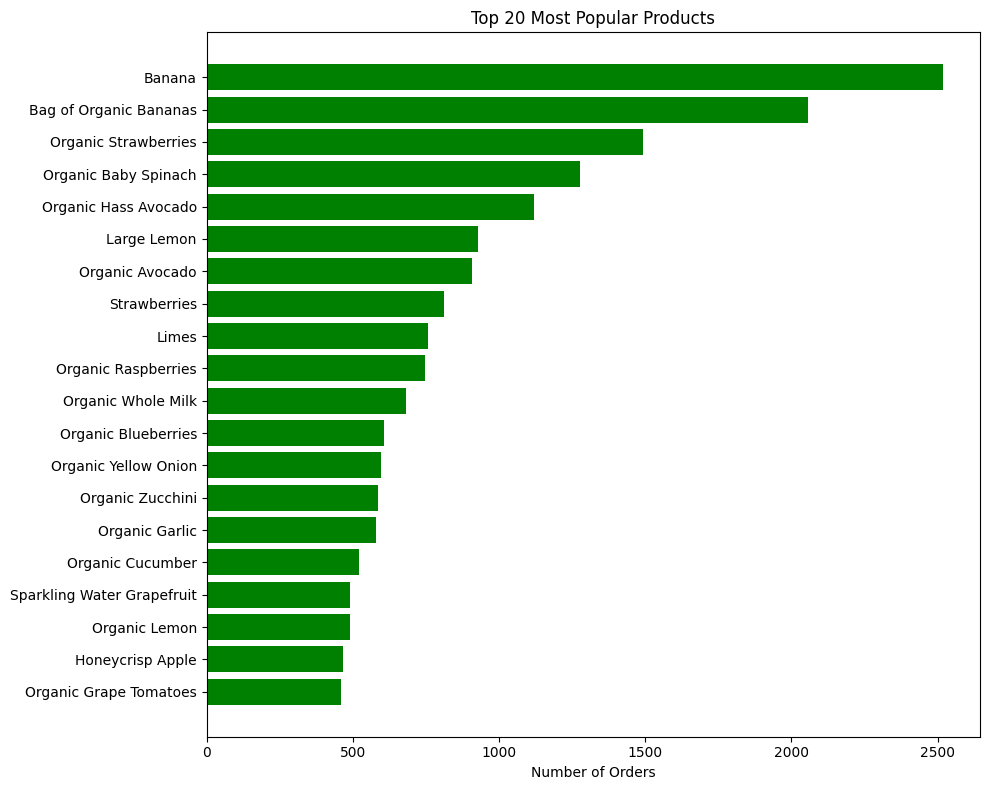

In [15]:
# Convert Spark DataFrame to Pandas
top_products_pd = most_popular_products.toPandas()

top_products_pd = top_products_pd.sort_values("count", ascending=True)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(top_products_pd["product_name"], top_products_pd["count"], color='green')
plt.xlabel("Number of Orders")
plt.title("Top 20 Most Popular Products")
plt.tight_layout()
plt.show()

In [16]:
# Print the 20 least popular products

least_popular_products = (
    stacked_df.groupBy("product_id").count()
    .join(products, on="product_id", how="inner")
    .sort("count", ascending=True)
    .limit(20)
)

least_popular_products.show()

+----------+-----+--------------------+--------+-------------+
|product_id|count|        product_name|aisle_id|department_id|
+----------+-----+--------------------+--------+-------------+
|     30660|    1|   Golden Mint Jelly|      88|           13|
|     24541|    1|Nonfat After Dark...|      37|            1|
|      1166|    1|Condensed Vegetab...|      69|           15|
|     47568|    1|Chocolate Chip Co...|      61|           19|
|     27039|    1|     Iced Tea, Peach|      94|            7|
|     13158|    1|Mini Chocolate Ch...|       8|            3|
|     47138|    1|Pinwheels Fudge &...|      61|           19|
|      6388|    1|Organic Cocoa Powder|      90|            7|
|     20452|    1|Organic Cheddar M...|       4|            9|
|     17344|    1|Assorted Flavors ...|      45|           19|
|     38741|    1|Stracciatella Gelato|      37|            1|
|     43626|    1|Ultra Moisturizin...|      55|           11|
|     35852|    1|Detoxify & Energi...|     127|       

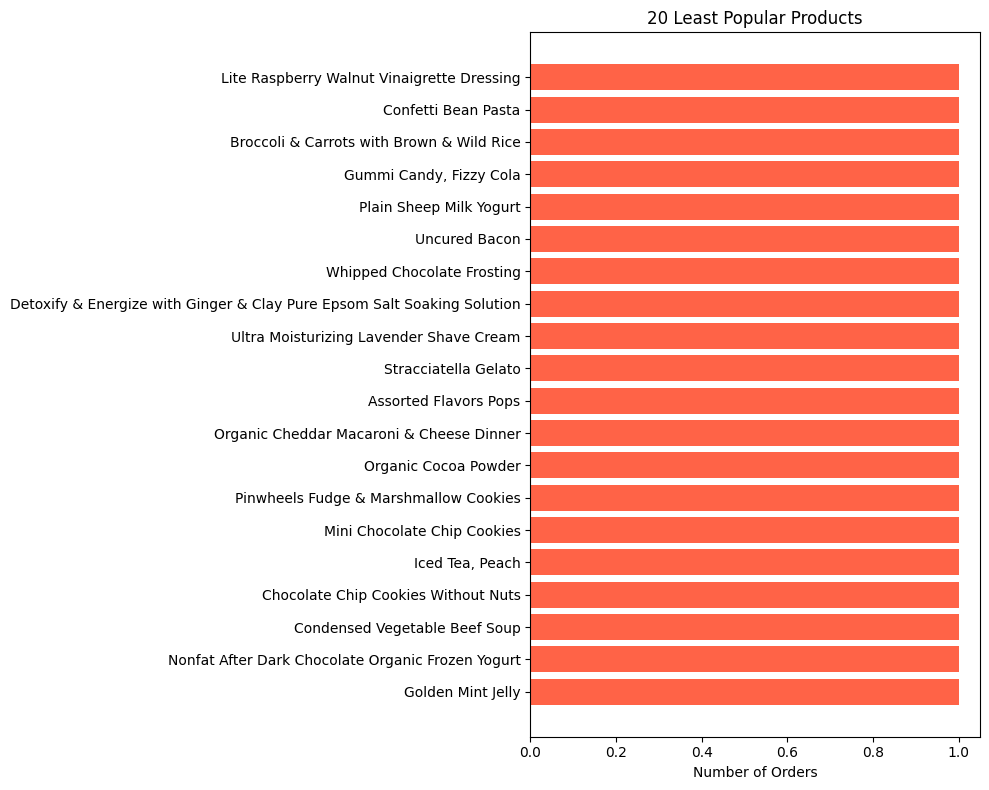

In [17]:
# Convert Spark DataFrame to Pandas
least_products_pd = least_popular_products.toPandas()

# Sort by count (just for display order)
least_products_pd = least_products_pd.sort_values("count", ascending=True)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(least_products_pd["product_name"], least_products_pd["count"], color='tomato')
plt.xlabel("Number of Orders")
plt.title("20 Least Popular Products")
plt.tight_layout()
plt.show()


In [18]:
# Check how many orders happen per hour
stacked_df.groupBy("order_hour_of_day") \
    .agg(count("order_id").alias("count")) \
    .sort("count", ascending=True) \
    .show()

+-----------------+-----+
|order_hour_of_day|count|
+-----------------+-----+
|                3|  235|
|                2|  283|
|                4|  438|
|                1|  605|
|                5|  646|
|                0| 1050|
|                6| 1711|
|               23| 2128|
|               22| 3498|
|               21| 4136|
|                7| 4349|
|               20| 5329|
|               19| 7069|
|               18| 9113|
|                8| 9876|
|               17|12146|
|                9|13487|
|               16|14392|
|               13|14417|
|               15|14600|
+-----------------+-----+
only showing top 20 rows



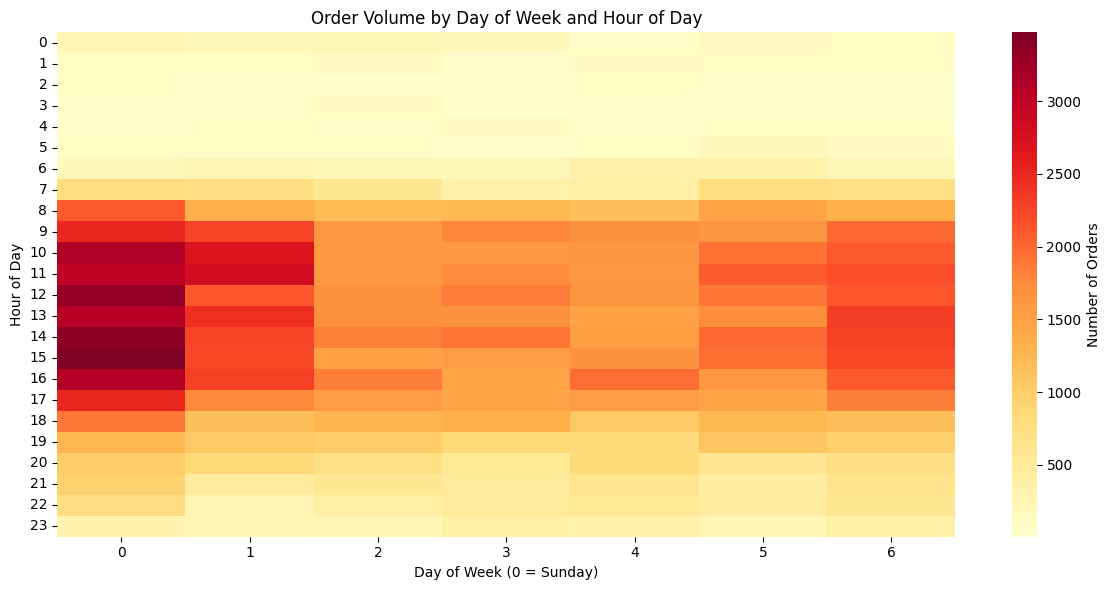

In [19]:
# Count number of orders for each day of week and hour of day
heatmap_df = stacked_df.groupBy("order_dow", "order_hour_of_day") \
    .agg(count("*").alias("order_count"))

heatmap_pd = heatmap_df.toPandas()

# Create pivot table: rows = hour, columns = day
heatmap_pivot = heatmap_pd.pivot(index="order_hour_of_day", columns="order_dow", values="order_count")


# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="YlOrRd", cbar_kws={"label": "Number of Orders"})

plt.title("Order Volume by Day of Week and Hour of Day")
plt.xlabel("Day of Week (0 = Sunday)")
plt.ylabel("Hour of Day")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

+-------------+------------+---------------+
|department_id|total_orders|     department|
+-------------+------------+---------------+
|            7|       14868|      beverages|
|           15|        5965|   canned goods|
|           11|        2583|  personal care|
|            3|        6510|         bakery|
|            8|         585|           pets|
|           16|       28724|     dairy eggs|
|            5|         746|        alcohol|
|           18|        1990|         babies|
|           17|        4351|      household|
|            6|        1487|  international|
|           19|       15890|         snacks|
|            9|        4826|dry goods pasta|
|            1|       12648|         frozen|
|           20|        5987|           deli|
|           10|         201|           bulk|
|            4|       52691|        produce|
|           12|        3845|   meat seafood|
|           13|       10315|         pantry|
|           14|        3915|      breakfast|
|         

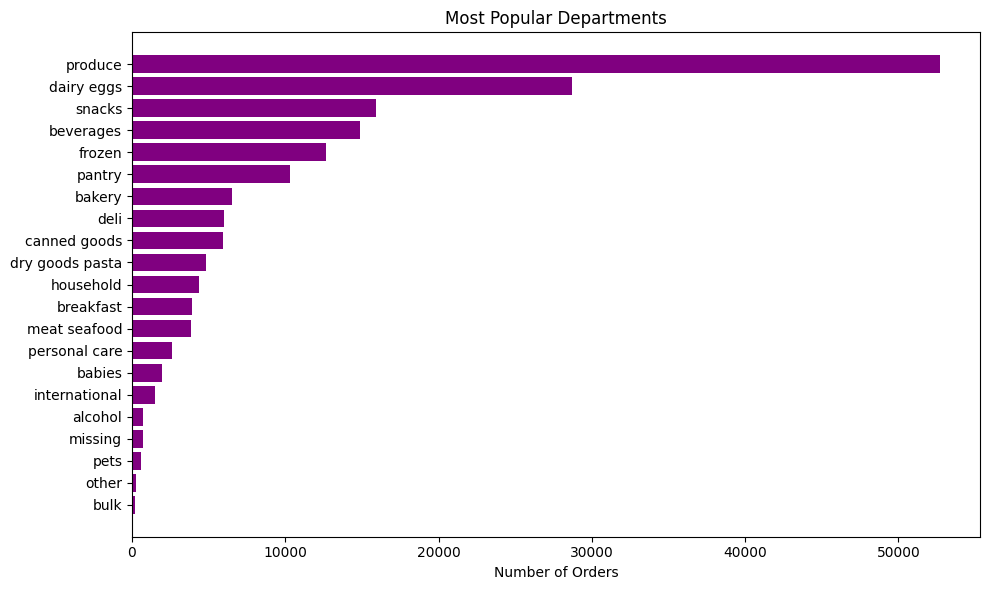

In [20]:
# Join stacked_df with products to get department_id for each product
df_departments = stacked_df.join(products, on="product_id", how="inner")

department_popularity = df_departments.groupBy("department_id") \
    .agg(count("*").alias("total_orders")) \
    .orderBy("total_orders", ascending=False)

most_popular_departments = department_popularity.join(departments, on="department_id", how="inner")
most_popular_departments.show()

# Convert to Pandas
dept_pd = most_popular_departments.toPandas().sort_values("total_orders", ascending=True)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(dept_pd["department"], dept_pd["total_orders"], color="purple")
plt.xlabel("Number of Orders")
plt.title("Most Popular Departments")
plt.tight_layout()
plt.show()


+--------+------------+--------------------+
|aisle_id|total_orders|               aisle|
+--------+------------+--------------------+
|      24|       19710|        fresh fruits|
|      83|       19319|    fresh vegetables|
|     123|        9926|packaged vegetabl...|
|     120|        7466|              yogurt|
|      21|        5287|     packaged cheese|
|     115|        4739|water seltzer spa...|
|      84|        4508|                milk|
|     107|        4084|      chips pretzels|
|      91|        3564|     soy lactosefree|
|     112|        3181|               bread|
|      31|        3137|        refrigerated|
|     116|        2945|      frozen produce|
|      37|        2850|       ice cream ice|
|      78|        2549|            crackers|
|      86|        2512|                eggs|
|       3|        2420| energy granola bars|
|      38|        2242|        frozen meals|
|      96|        2218|          lunch meat|
|     121|        2143|              cereal|
|      16|

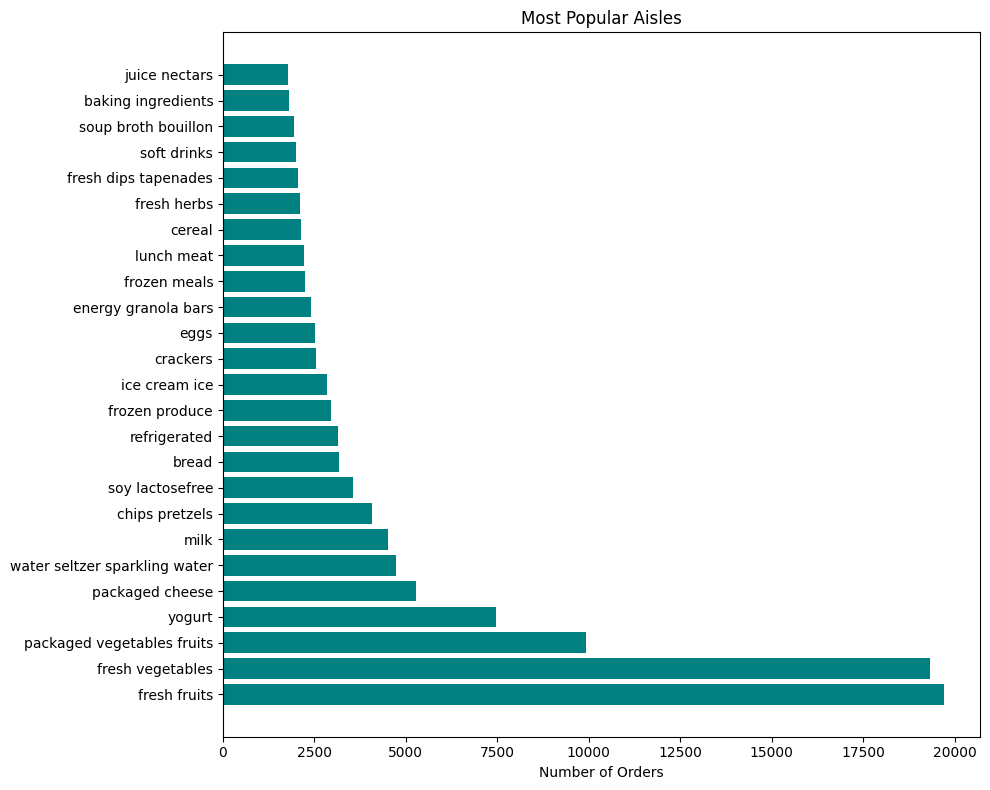

In [21]:
# To check which aisles are the most popular
df_with_aisles = stacked_df.join(products, on="product_id", how="inner")

aisle_popularity = df_with_aisles.groupBy("aisle_id") \
    .agg(count("*").alias("total_orders")) \
    .orderBy("total_orders", ascending=False)

most_popular_aisles = aisle_popularity.join(aisles, on="aisle_id", how="inner")
most_popular_aisles.orderBy("total_orders", ascending=False).show()

# Convert to pandas and keep the top 25 for plotting
aisle_pd = most_popular_aisles.toPandas().sort_values("total_orders", ascending=False).head(25)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(aisle_pd["aisle"], aisle_pd["total_orders"], color="teal")
plt.xlabel("Number of Orders")
plt.title("Most Popular Aisles")
plt.tight_layout()
plt.show()

In [22]:
# Top selling aisles within each department
df_joined = stacked_df.join(products, "product_id", "inner") \
                      .join(aisles, "aisle_id", "inner") \
                      .join(departments, "department_id", "inner")

# Create treemap data: total orders per (department, aisle) pair
df_treemap = df_joined.groupBy("department", "aisle") \
                      .agg(count("*").alias("total_orders"))

treemap_pd = df_treemap.toPandas()

import plotly.express as px

fig = px.treemap(
    treemap_pd,
    path=["department", "aisle"],
    values="total_orders",
    color="total_orders",  # Color by volume
    color_continuous_scale="YlGnBu",
    title="Top-Selling Aisles Within Each Department"
)

fig.show()

In [23]:
# Group by reordered
reorder_counts = stacked_df.groupBy("reordered") \
    .agg(count("*").alias("count")) \
    .orderBy("reordered")

# Convert to Pandas
reorder_pd = reorder_counts.toPandas()

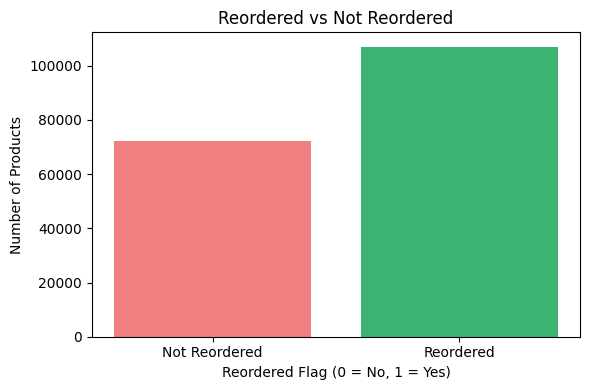

In [24]:
# Plot directly without .tolist()
plt.figure(figsize=(6, 4))
plt.bar(reorder_pd["reordered"], reorder_pd["count"], color=["lightcoral", "mediumseagreen"])
plt.title("Reordered vs Not Reordered")
plt.xlabel("Reordered Flag (0 = No, 1 = Yes)")
plt.ylabel("Number of Products")
plt.xticks([0, 1], ["Not Reordered", "Reordered"])
plt.tight_layout()
plt.show()

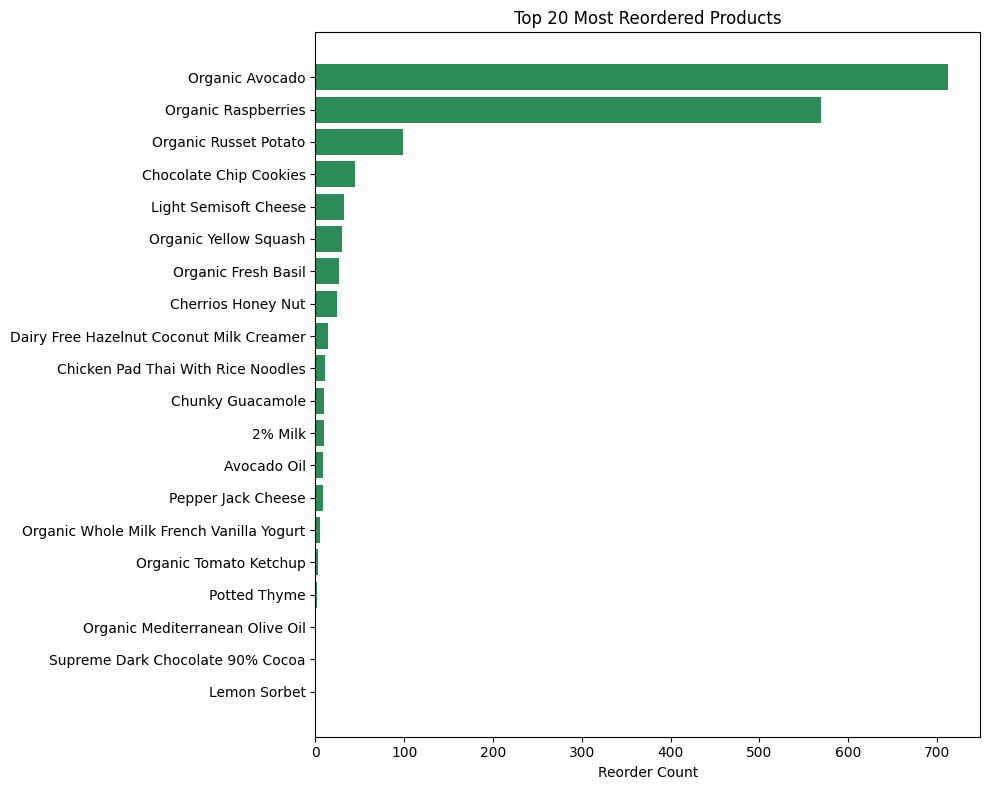

In [25]:
from pyspark.sql.functions import sum

# Get total reorder count per product (only where reordered = 1)
reordered_counts = stacked_df.filter(stacked_df.reordered == 1) \
    .groupBy("product_id") \
    .agg(sum("reordered").alias("reorder_count")) \
    .orderBy("reorder_count", ascending=False)

# Add product names to reorder counts
most_reordered_products = reordered_counts.join(products, on="product_id", how="inner")

# Keep only the top 20 most reordered products
top_reordered = most_reordered_products.limit(20)

# Convert to pandas
top_reordered_pd = top_reordered.toPandas().sort_values("reorder_count", ascending=True)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(top_reordered_pd["product_name"], top_reordered_pd["reorder_count"], color="seagreen")
plt.xlabel("Reorder Count")
plt.title("Top 20 Most Reordered Products")
plt.tight_layout()
plt.show()


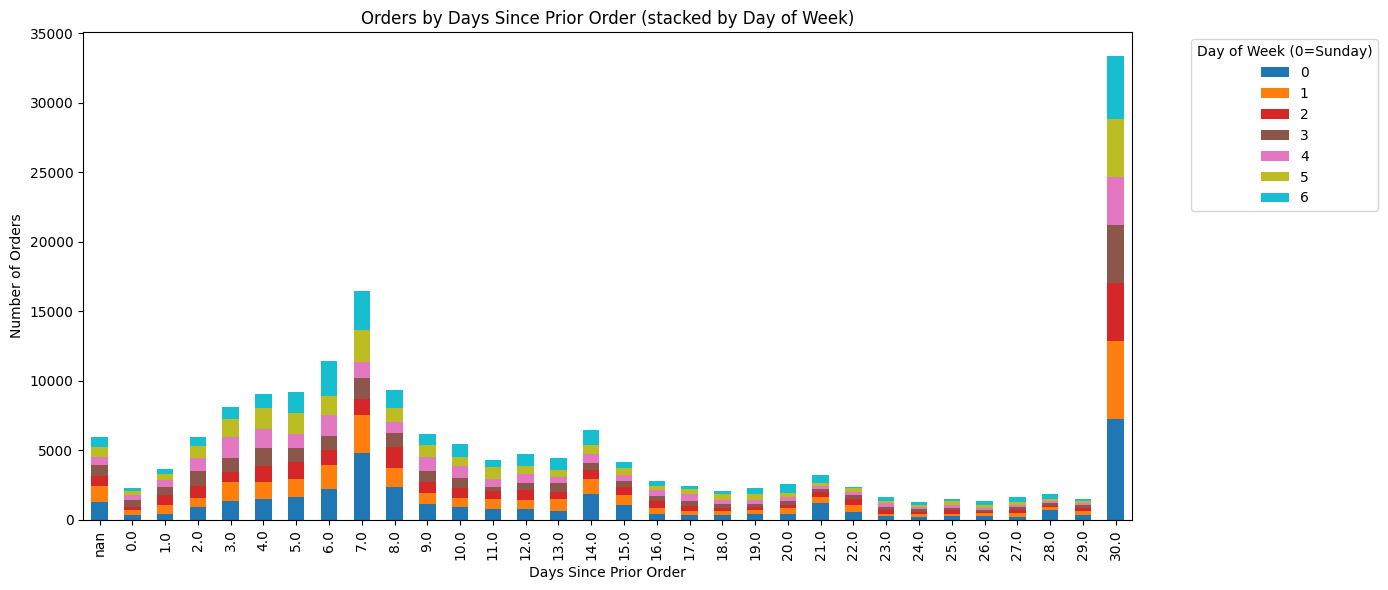

In [26]:
# Group by days_since_prior_order and order_dow
grouped_orders = stacked_df.groupBy("days_since_prior_order", "order_dow") \
    .agg(count("*").alias("order_count"))

# Convert to pandas
grouped_pd = grouped_orders.toPandas()

# Pivot so days_since_prior_order becomes index, order_dow becomes columns
pivot_df = grouped_pd.pivot(index="days_since_prior_order", columns="order_dow", values="order_count")

# Set column order to match days (0 = Sunday to 6 = Saturday)
pivot_df = pivot_df[[0, 1, 2, 3, 4, 5, 6]]

# Plot
pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6),
    colormap="tab10"
)

plt.title("Orders by Days Since Prior Order (stacked by Day of Week)")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Number of Orders")
plt.legend(title="Day of Week (0=Sunday)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 📊 Exploratory Data Analysis (EDA)

- **Data Quality Checks**:
  - No missing values or duplicate rows in product, aisle, or department data.
  - `orders` dataset had ~206,000 missing `days_since_prior_order` values (likely first-time orders).
  
- **Reorder Distribution**:
  - Around 60% of products in the dataset were reordered at least once, confirming imbalance.
  - Many reordered items were healthy/organic foods (e.g. juice, carrots, spinach).

- **Top Products**:
  - Many popular products include bananas, organic fruits, and milk.

- **Aisles & Departments**:
  - **Produce** is the top department by far.
  - Treemap shows Produce aisles (fresh fruits/veggies) dominate across departments.

- **Order Timing Trends**:
  - Highest ordering hours are from **9am to 3pm**.
  - Weekends (especially Sunday) have visibly more order traffic.
  - Many users reorder every **7 days**. The **30 days** mark likely reflects a cap or max value in the dataset, but it doesn’t impact our project in any meaningful way.


## Feature Selection and Extraction

### 🔍 Feature Selection and Extraction

In this section, we engineered and combined several product-level features and labeled them for training:

- **Average Cart Position**: Computed the average position a product is added to the cart (`avg_cart_position`) to capture product priority during shopping.

- **Total Orders and Reorders**: Calculated how often each product was ordered (`total_orders`) and how many of those were reorders (`total_reorders`).

- **Label Assignment**: Identified products reordered in the training set and labeled them with `1`, treating others as `0`.

- **Category Info**: Added product metadata (`aisle_id`, `department_id`) to enrich features.

- **All Orders**: Combined prior and train order-product records to build a complete view (`all_orders`) and joined it with product features and order-level data.

- **Final Dataset Cleanup**:
  - Merged with full product details.
  - Renamed duplicated columns from joins (e.g., `product_id_1`, `product_id_2`, etc.).
  - Dropped repeated columns to ensure `official_df` has unique, clean column names.

In [27]:
# Compute the average cart position for each product
avg_cart_position = order_prior.groupBy("product_id") \
    .agg(F.avg("add_to_cart_order").alias("avg_cart_position"))

# Compute the total orders per product
total_orders = order_prior.groupBy("product_id") \
    .agg(F.count("order_id").alias("total_orders"))

# Compute the total reorders
total_reorders = order_prior.groupBy("product_id").agg(
    F.sum("reordered").alias("total_reorders")
)

# Join these features together into one DataFrame
features = avg_cart_position.join(total_orders, on="product_id", how="inner")
features1 = features.join(total_reorders, on="product_id", how="inner")
features1.show()

+----------+------------------+------------+--------------+
|product_id| avg_cart_position|total_orders|total_reorders|
+----------+------------------+------------+--------------+
|     41890| 9.372549019607844|          51|            35|
|      8592| 6.833333333333333|          24|            13|
|     29228|11.133333333333333|          15|             4|
|     40386| 7.540983606557377|          61|            37|
|     42834| 8.785714285714286|          42|            25|
|      8638| 8.055555555555555|         108|            58|
|     18498| 9.055555555555555|          18|             9|
|     28836| 8.074074074074074|         108|            69|
|       148|10.118181818181819|         110|            69|
|     40574|10.384615384615385|          13|             6|
|      9852| 8.615384615384615|          13|             3|
|     17389|               7.5|          10|             2|
|     38153|               5.5|           2|             2|
|     38395| 8.571428571428571|         

In [28]:
# Get all unique products that were reordered in the training set and assign label 1
reordered_products = order_train.filter("reordered = 1") \
    .select("product_id").distinct() \
    .withColumn("label", F.lit(1))

# Join product features with the reordered labels, filling missing labels with 0
labeled_df = features1.join(reordered_products, on="product_id", how="left") \
    .fillna(0, subset=["label"])

In [29]:
labeled_df.show(5)

+----------+------------------+------------+--------------+-----+
|product_id| avg_cart_position|total_orders|total_reorders|label|
+----------+------------------+------------+--------------+-----+
|     41890| 9.372549019607844|          51|            35|    1|
|      8592| 6.833333333333333|          24|            13|    1|
|     29228|11.133333333333333|          15|             4|    1|
|     40386| 7.540983606557377|          61|            37|    1|
|     42834| 8.785714285714286|          42|            25|    1|
+----------+------------------+------------+--------------+-----+
only showing top 5 rows



In [30]:
product_info = products.select("product_id", "aisle_id", "department_id")

labeled_df = labeled_df.join(product_info, on="product_id", how="left")

In [31]:
labeled_df.show(5)

+----------+------------------+------------+--------------+-----+--------+-------------+
|product_id| avg_cart_position|total_orders|total_reorders|label|aisle_id|department_id|
+----------+------------------+------------+--------------+-----+--------+-------------+
|     41890| 9.372549019607844|          51|            35|    1|     121|           14|
|      8592| 6.833333333333333|          24|            13|    1|      31|            7|
|     29228|11.133333333333333|          15|             4|    1|      72|           13|
|     40386| 7.540983606557377|          61|            37|    1|      26|            7|
|     42834| 8.785714285714286|          42|            25|    1|     123|            4|
+----------+------------------+------------+--------------+-----+--------+-------------+
only showing top 5 rows



In [32]:
# Union merged prior and merged train datasets to capture all order-product details
all_orders = merged_prior.union(merged_train)

In [33]:
enriched_orders = all_orders.join(features, on='product_id', how='left')
enriched_orders.show()

+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+------------------+------------+
|product_id|order_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order| avg_cart_position|total_orders|
+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+------------------+------------+
|       162|      14|                3|        1|  18194|   prior|          49|        3|               15|                   3.0|  8.48062015503876|         129|
|      2452|      14|                4|        1|  18194|   prior|          49|        3|               15|                   3.0|10.268085106382978|         235|
|      4818|     988|                4|        1|    310|   train|         100|        2|                9|                   4.0|             6.125|          16|
|      6046|    1275| 

In [34]:
# Join user and order info to the enriched orders
final_df = enriched_orders.join(orders, on='order_id', how='left')

In [35]:
final_df.show()

+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+------------------+------------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order| avg_cart_position|total_orders|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+------------------+------------+-------+--------+------------+---------+-----------------+----------------------+
|       6|     15873|                2|        0|  22352|   prior|           4|        1|               12|                  30.0|               4.0|           2|  22352|   prior|           4|        1|               12|                  30.0|
|      40|     10070|   

In [36]:
# Join full product details to the final DataFrame
official_df = final_df.join(products, on='product_id',how='inner')

In [37]:
official_df.columns

['product_id',
 'order_id',
 'add_to_cart_order',
 'reordered',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'avg_cart_position',
 'total_orders',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'product_name',
 'aisle_id',
 'department_id']

In [38]:
from collections import Counter
import re

# Get the original column names (with duplicates)
orig_names = official_df.schema.names
counts     = Counter(orig_names)

# Create a new name for each column, appending '_1', '_2', ... on duplicates
name_counts = Counter()
new_names   = []
for name in orig_names:
    idx = name_counts[name]
    if idx == 0:
        new_names.append(name)
    else:
        new_names.append(f"{name}_{idx}")
    name_counts[name] += 1

# Rename the Dataframe with the new unique column names
official_df = official_df.toDF(*new_names)

# Identify and drop all duplicated columns (with suffixes like _1, _2, etc.)
to_drop = []
for name, cnt in counts.items():
    for i in range(1, cnt):
        to_drop.append(f"{name}_{i}")

official_df = official_df.drop(*to_drop)

# Now official_df.columns will list each name only once
print(official_df.columns)


['product_id', 'order_id', 'add_to_cart_order', 'reordered', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'avg_cart_position', 'total_orders', 'product_name', 'aisle_id', 'department_id']


In [39]:
official_df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- avg_cart_position: double (nullable = true)
 |-- total_orders: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



In [40]:
official_df.show()

+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+-----------------+------------+--------------------+--------+-------------+
|product_id|order_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|avg_cart_position|total_orders|        product_name|aisle_id|department_id|
+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+-----------------+------------+--------------------+--------+-------------+
|         1|   19989|                1|        0|   4122|   prior|          11|        2|                7|                   8.0|5.673469387755102|          49|Chocolate Sandwic...|      61|           19|
|         1|   38944|                6|        0|  22561|   prior|           4|        6|               21|                  23.0|5.673469387755102|          49|Chocolate Sandw

In [41]:
official_df.toPandas().to_csv("official_df.csv", index=False)

## Classification

### 📊 Classification

In this section, we trained classifiers to predict whether a product will be reordered by a user. Since the dataset is imbalanced, we used **AUC** and **F1 score** as our evaluation metrics.


We used the `order_prior` dataset to engineer features based on past shopping behavior. We then used the `order_train` dataset to label products as `reordered` (`1`) or not (`0`), forming a product-level labeled dataset.


We split this labeled dataset into training and testing sets using an 80/20 random split.

⚠️ **Important note on `eval_set = 'test'`:**  
The `orders` table includes rows where `eval_set == 'test'`, but these are **only used for making final predictions** in the original Kaggle competition we sourced our data from. There are **no labels (reordered values)** for these test orders in the dataset. For our project, we do **not** use them at all, since we are not submitting predictions on the entire list of items a user might order next — we only train and evaluate using `order_prior` and `order_train`.

We built two models:
- **Logistic Regression**
- **Random Forest**

Both were wrapped in a pipeline that included preprocessing (indexing, encoding, assembling features). After training, we evaluated both models on the test set using AUC and F1. We also inspected feature importances for the Random Forest model and generated a confusion matrix.


In [42]:
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [43]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [44]:
labeled_df.schema["label"].dataType

IntegerType()

In [45]:
# Train/test split
train_df, test_df = labeled_df.randomSplit([0.8, 0.2], seed=42)

In [46]:
# Index and encode categoricals
aisle_indexer = StringIndexer(inputCol="aisle_id", outputCol="aisle_index")
dept_indexer  = StringIndexer(inputCol="department_id", outputCol="dept_index")
aisle_encoder = OneHotEncoder(inputCol="aisle_index", outputCol="aisle_vec")
dept_encoder  = OneHotEncoder(inputCol="dept_index", outputCol="dept_vec")

In [47]:
# Assemble features
feature_cols = [
    "avg_cart_position",
    "total_orders",
    "total_reorders",
    "aisle_vec",
    "dept_vec"
]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [48]:
# Create evaluator for AUC (area under ROC curve)
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Create evaluator for F1 score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

In [49]:
# Define logistic regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Create pipeline with preprocessing steps and logistic regression
lr_pipeline = Pipeline(stages=[
    aisle_indexer,
    dept_indexer,
    aisle_encoder,
    dept_encoder,
    assembler,
    lr
])

In [50]:
# Train logistic regression pipeline on training data
lr_model = lr_pipeline.fit(train_df)

# Make predictions on test data
lr_predictions = lr_model.transform(test_df)

In [51]:
# Evaluate AUC and F1 score for logistic regression
lr_auc = evaluator.evaluate(lr_predictions)
lr_f1 = f1_evaluator.evaluate(lr_predictions)

print(f"Logistic Regression AUC: {lr_auc:.4f}")
print(f"Logistic Regression F1 Score: {lr_f1:.4f}")

Logistic Regression AUC: 0.8600
Logistic Regression F1 Score: 0.7847


In [52]:
# Define random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [53]:
# Create pipeline with preprocessing steps and random forest
pipeline = Pipeline(stages=[
    aisle_indexer,
    dept_indexer,
    aisle_encoder,
    dept_encoder,
    assembler,
    rf
])

In [54]:
# Train the random forest pipeline on training data
model = pipeline.fit(train_df)

In [55]:
# Make predictions on the test set
predictions = model.transform(test_df)

In [56]:
# Imbalanced so we will use AUC and F1 as evaluation metrics

# Evaluate Random Forest
rf_auc = evaluator.evaluate(predictions)
print(f"AUC = {rf_auc:.4f}")

rf_f1 = f1_evaluator.evaluate(predictions)
print(f"Test F1 Score: {rf_f1:.4f}")

# Train set metrics
train_predictions = model.transform(train_df)
print(f"Train F1 Score: {f1_evaluator.evaluate(train_predictions):.4f}")


AUC = 0.8398
Test F1 Score: 0.6772
Train F1 Score: 0.6850


In [57]:
# Get the trained Random Forest model from the pipeline
rf_model = model.stages[-1]

# Get importances
importances = rf_model.featureImportances.toArray()

# Feature names
feature_names = ["total_orders", "total_reorders", "avg_cart_position"] + ["aisle_vec", "dept_vec"]

# Print top features
print("Feature Importances:")
for name, imp in zip(feature_names, importances):
    print(f"{name:<20} → {imp:.4f}")


Feature Importances:
total_orders         → 0.0793
total_reorders       → 0.2801
avg_cart_position    → 0.2958
aisle_vec            → 0.0119
dept_vec             → 0.0000


In [58]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# Compute confusion matrix by counting label-prediction pairs in test predictions
conf_matrix = (
    predictions.groupBy("label", "prediction")
    .agg(F.count("*").alias("count"))
    .orderBy("label", "prediction")
)

conf_matrix.show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  524|
|    0|       1.0| 1605|
|    1|       0.0|  202|
|    1|       1.0| 4262|
+-----+----------+-----+



# Grocery Purchase Analysis & Recommendations

This section demonstrates 3 complementary pipelines for exploring and recommending products based on user purchase histories:

* **User Clustering via MinHash LSH & GraphFrames**  
   - Load transactional data (`official_df.csv`), extract user–item sets  
   - Build binary “features” vectors with `HashingTF`  
   - Approximate user–user Jaccard similarities with `MinHashLSH`  
   - Filter similar user pairs, construct a GraphFrame, and find connected components  
   - Visualize a sampled user‐similarity graph with NetworkX

* **Bipartite User–Product Graph Construction & Visualization**  
   - Create unified vertices (prefixing IDs: `u_<user>`, `p_<product>`)  
   - Build edges carrying the `reordered` flag as weight  
   - Visualize any two users’ product sets (shared vs. unique) in a directed graph

* **Neighborhood-Based Collaborative Filtering**  
   - Reuse MinHashLSH user similarities to define “neighbors” (distance below a threshold)  
   - Generate candidate recommendations: items purchased by neighbors but not by the target user  
   - Score candidates by neighbor vote counts and pick the top‐N per user  
   - Inspect neighbor counts and sample recommendations for a handful of users




In [59]:
from pyspark.storagelevel import StorageLevel

In [60]:
# Load only user and product IDs
df = (
    spark.read
         .csv("official_df.csv", header=True, inferSchema=True)
         .select("user_id", "product_id")
)

# Rename and aggregate
df = df.withColumnRenamed("product_id", "item") \
       .groupBy("user_id") \
       .agg(collect_list("item").alias("items"))

# Vectorize with HashingTF (binary membership)
hashingTF = HashingTF(inputCol="items", outputCol="features",
                      numFeatures=10_000, binary=True)
df = hashingTF.transform(df)

# MinHash LSH model
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=3)
mh_model = mh.fit(df)
df = mh_model.transform(df)

# Cache after MinHash transform
df = df.persist(StorageLevel.MEMORY_AND_DISK)

# Approximate similarity join (Jaccard similarity > 0.1)
#    distance = 1 − similarity
similar_pairs = mh_model.approxSimilarityJoin(df, df, 0.9,
                                              distCol="JaccardDistance")

# Filter out self‐matches and show results
non_self = similar_pairs.filter("datasetA.user_id != datasetB.user_id")
non_self.select(
    "datasetA.user_id",
    "datasetB.user_id",
    "JaccardDistance"
).show(truncate=False)

# Build GraphFrame and find connected components
vertices = df.select("user_id").distinct().withColumnRenamed("user_id","id")
edges    = non_self.selectExpr(
               "datasetA.user_id AS src",
               "datasetB.user_id AS dst",
               "JaccardDistance"
           )

g = GraphFrame(vertices, edges)
clusters = g.connectedComponents()
clusters.select("id","component").show(truncate=False)


+-------+-------+------------------+
|user_id|user_id|JaccardDistance   |
+-------+-------+------------------+
|20683  |13129  |0.75              |
|1342   |909    |0.8571428571428572|
|1829   |19745  |0.8571428571428572|
|20683  |23973  |0.875             |
|1580   |16000  |0.8888888888888888|
|7982   |16310  |0.8888888888888888|
|8086   |12424  |0.8076923076923077|
|11458  |17455  |0.875             |
|11458  |12674  |0.875             |
|12799  |8325   |0.8947368421052632|
|16574  |8871   |0.8775510204081632|
|20683  |16741  |0.6666666666666667|
|496    |6553   |0.875             |
|7833   |468    |0.875             |
|7833   |6192   |0.875             |
|7833   |9302   |0.875             |
|7833   |21883  |0.8571428571428572|
|8086   |1426   |0.8518518518518519|
|13289  |16301  |0.8461538461538461|
|7833   |8726   |0.875             |
+-------+-------+------------------+
only showing top 20 rows



/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning:

DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:147: UserWarning:

DataFrame constructor is internal. Do not directly use it.



+----+---------+
|id  |component|
+----+---------+
|471 |471      |
|496 |1        |
|833 |1        |
|1088|1        |
|1342|1        |
|1580|1        |
|1645|1645     |
|1829|1        |
|2122|1        |
|2366|1        |
|2659|2659     |
|2866|1        |
|3175|3175     |
|3794|1        |
|4900|4900     |
|5156|5156     |
|5518|1        |
|5803|5803     |
|6357|1        |
|6620|1        |
+----+---------+
only showing top 20 rows



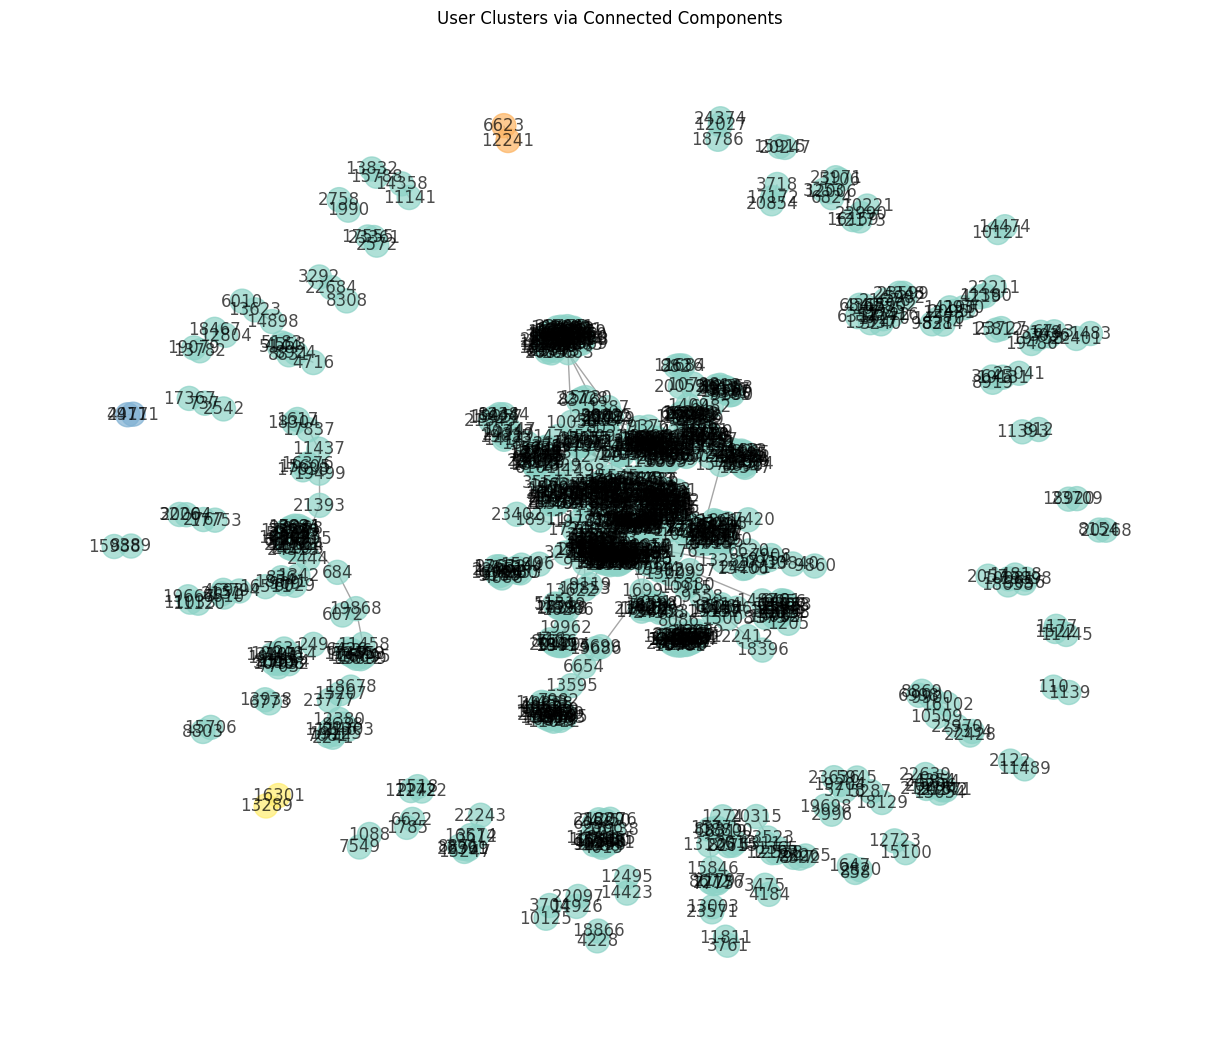

In [61]:
import networkx as nx
import matplotlib.pyplot as plt

# Take a sample of 1000 edges and vertices for visualization
sampled_edges = edges.limit(1000).select("src", "dst", "JaccardDistance")
sampled_vertices = vertices.limit(1000).select("id")

# Convert Spark DataFrames to Pandas
edges_pd = sampled_edges.toPandas()
vertices_pd = sampled_vertices.toPandas()

# Get cluster assignments for each user
clusters_pd = clusters.join(vertices, clusters.id == vertices.id, "inner") \
                      .select(vertices.id, "component") \
                      .toPandas()

# Create NetworkX graph from edge list
G = nx.from_pandas_edgelist(edges_pd, source='src', target='dst', edge_attr='JaccardDistance')

# Map user IDs to cluster IDs
cluster_dict = dict(zip(clusters_pd['id'], clusters_pd['component']))

# For each node in the graph, assign a color based on its cluster component.
# If a node is missing from the cluster_dict, default to 0.
node_colors = [cluster_dict.get(node, 0) for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    cmap=plt.cm.Set3,
    node_size=300,
    edge_color='gray',
    alpha=0.7
)
plt.title("User Clusters via Connected Components")
plt.show()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning:

DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.



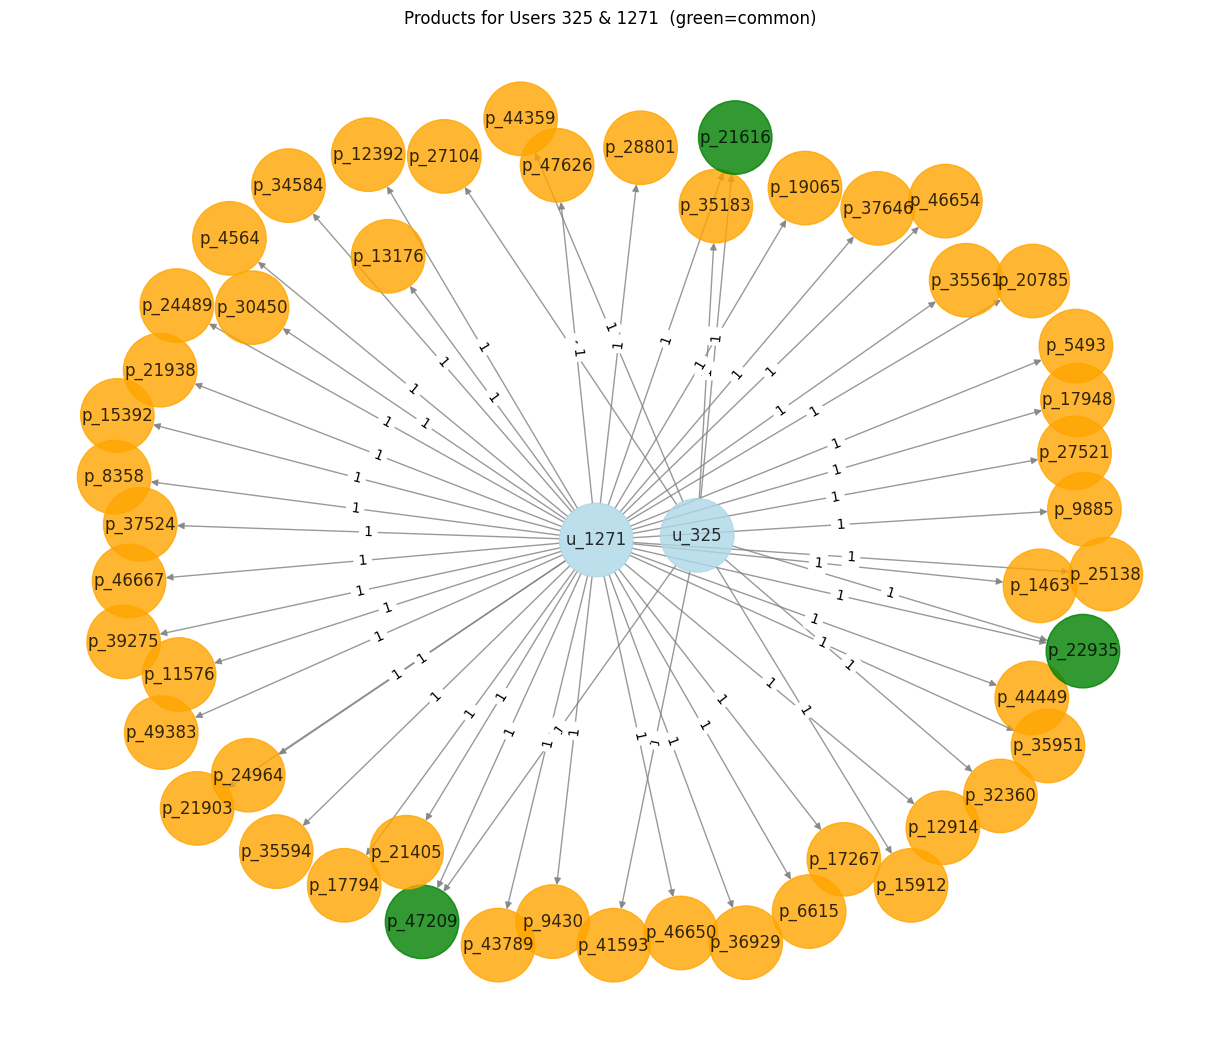

In [62]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, concat
from graphframes import GraphFrame

# Load user-product interaction data
tx = (
    spark.read
         .csv("official_df.csv", header=True, inferSchema=True)
         .select("user_id", "product_id", "product_name", "reordered")
)

# Build user vertices (prefix with "u_")
users_df = (
    tx.select(col("user_id").alias("id"))
      .distinct()
      .withColumn("id", concat(lit("u_"), col("id")))
      .withColumn("type", lit("user"))
      .withColumn("product_name", lit(None).cast("string"))
)

# Build product vertices (prefix with "p_")
products_df = (
    tx.select(col("product_id").alias("id"), "product_name")
      .distinct()
      .withColumn("id", concat(lit("p_"), col("id")))
      .withColumn("type", lit("product"))
)

# Combine users and products into one vertex set
vertices = users_df.unionByName(products_df) \
                   .persist(StorageLevel.MEMORY_ONLY)

# Build edges from users to products, carrying the reorder flag as weight
edges = (
    tx.select("user_id", "product_id", "reordered")
      .distinct()
      .withColumn("src", concat(lit("u_"), col("user_id")))
      .withColumn("dst", concat(lit("p_"), col("product_id")))
      .select("src", "dst", col("reordered").alias("weight"))
      .persist(StorageLevel.MEMORY_ONLY)
)

# Create the GraphFrame
g = GraphFrame(vertices, edges)

# Visualization helper using NetworkX and Matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def visualize_user_pair_graph(gf, user1_raw, user2_raw, node_size=2800):
    # Format user IDs with prefix
    u1, u2 = f"u_{user1_raw}", f"u_{user2_raw}"

    # Get product edges for both users
    e1 = gf.edges.filter(col("src")==u1).toPandas()
    e2 = gf.edges.filter(col("src")==u2).toPandas()

    # Get product sets and their union/intersection
    p1 = set(e1.dst)
    p2 = set(e2.dst)
    union_p = p1 | p2
    common_p = p1 & p2

    # Get vertex info for both users and related products
    verts = (
        gf.vertices
          .filter(col("id").isin([u1, u2] + list(union_p)))
          .toPandas()
    )

    # Build NetworkX graph
    G = nx.DiGraph()
    for _, r in verts.iterrows():
        G.add_node(r.id, type=r.type)
    for df in (e1, e2):
        for _, r in df.iterrows():
            if r.dst in union_p:
                G.add_edge(r.src, r.dst, weight=r.weight or 1)

    # Layout & colors
    pos = nx.spring_layout(G, seed=42)
    color_map = []
    for n, data in G.nodes(data=True):
        if data['type']=="user":
            color_map.append('lightblue')
        elif n in common_p:
            color_map.append('green')
        else:
            color_map.append('orange')

    # Draw
    plt.figure(figsize=(12,10))
    nx.draw(G, pos, with_labels=True,
            node_size=node_size,
            node_color=color_map,
            edge_color='gray', alpha=0.8)
    edge_lbl = {(u,v):d['weight'] for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_lbl)
    plt.title(f"Products for Users {user1_raw} & {user2_raw}  (green=common)")
    plt.show()

# Example comparison between two users
visualize_user_pair_graph(g, user1_raw=325, user2_raw=1271)

In [63]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, collect_list, count, desc, row_number, rand
)
from pyspark.sql.window import Window
from pyspark.ml.feature import HashingTF, MinHashLSH

In [64]:
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import broadcast

# Load & cache the raw tx once
tx = (
    spark.read
         .csv("official_df.csv", header=True, inferSchema=True)
         .select("user_id", "product_id", "reordered")
         .persist(StorageLevel.MEMORY_AND_DISK)
)

# Build (user, item) pairs and cache
user_items = (
    tx
    .select(
        col("user_id").alias("user"),
        col("product_id").alias("item")
    )
    .distinct()
    .persist(StorageLevel.MEMORY_ONLY)
)

# Feature engineering: hash & LSH
user_feats = (
    user_items
    .groupBy("user")
    .agg(collect_list("item").alias("items"))
)

hashingTF = HashingTF(
    inputCol="items", outputCol="features",
    numFeatures=5_000,
    binary=True
)
user_feats = hashingTF.transform(user_feats)

mh = MinHashLSH(
    inputCol="features", outputCol="hashes",
    numHashTables=2       # fewer tables = faster, but less accurate
)
mh_model = mh.fit(user_feats)

# Cache after LSH as it is a computationally expensive step
user_feats = (
    mh_model
      .transform(user_feats)
      .persist(StorageLevel.MEMORY_AND_DISK)   # cache here
)

# Tune shuffle parallelism once per session
spark.conf.set("spark.sql.shuffle.partitions", 200)

# Similarity join
raw_pairs = mh_model.approxSimilarityJoin(
    user_feats, user_feats,
    1.0 - 0.2,   # maxDistance
    distCol="JaccardDistance"
)
neighbors = (
    raw_pairs
    .filter("datasetA.user != datasetB.user")
    .selectExpr(
        "datasetA.user  AS user",
        "datasetB.user  AS neighbor",
        "JaccardDistance"
    )
    .distinct()
    .persist(StorageLevel.MEMORY_ONLY)         # cache for later use
)

# Get items from each user's neighbors using a broadcast join
neighbor_items = (
    neighbors
      .join(
          broadcast(user_items),               # broadcast for faster join
          neighbors.neighbor == user_items.user
      )
      .select(
          neighbors.user,
          user_items.item
      )
)

# Score & filter
candidate_scores = (
    neighbor_items
    .groupBy("user","item")
    .agg(count("*").alias("score"))
)

scores_filtered = candidate_scores.join(
    broadcast(user_items),    # broadcast again
    on=["user","item"],
    how="left_anti"
)

# Rank top-N with a partition-by “user” repartition
N = 10
window = Window.partitionBy("user").orderBy(desc("score"))

topN = (
    scores_filtered
    .repartition("user")     # group each user's records together
    .withColumn("rank", row_number().over(window))
    .filter(col("rank") <= N)
    .persist()                # keep in memory
)

# Show top-N recommendations for 5 random users with neighbors
neighbor_counts = (
    neighbors
      .groupBy("user")
      .agg(count("*").alias("num_neighbors"))
)

active_users = neighbor_counts.filter(col("num_neighbors") > 0).select("user")

sample_users = (
    active_users
      .orderBy(rand(42))
      .limit(5)
)

sample_recs = (
    topN
      .join(broadcast(sample_users), on="user", how="inner")
      .orderBy("user","rank")
)

sample_recs.show(truncate=False)


+-----+-----+-----+----+
|user |item |score|rank|
+-----+-----+-----+----+
|508  |7751 |1    |1   |
|714  |21137|2    |1   |
|714  |12015|2    |2   |
|714  |13176|2    |3   |
|714  |26104|1    |4   |
|714  |14979|1    |5   |
|714  |7252 |1    |6   |
|714  |47209|1    |7   |
|714  |9076 |1    |8   |
|714  |14084|1    |9   |
|714  |9839 |1    |10  |
|4576 |41290|1    |1   |
|4576 |13176|1    |2   |
|4576 |4037 |1    |3   |
|4576 |27845|1    |4   |
|4576 |5068 |1    |5   |
|4576 |33249|1    |6   |
|4576 |12341|1    |7   |
|16323|46061|2    |1   |
|16323|9076 |1    |2   |
+-----+-----+-----+----+
only showing top 20 rows

